In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{path}")

In [5]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(latest_date.date)

2017-08-23


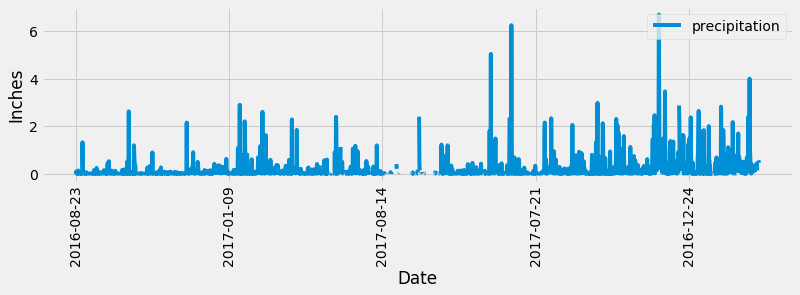

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query1 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query1, columns=['date', 'precipitation'])
# df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', figsize=(12,3), rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc = "upper right")
# plt.xticks(np.arange(8, 365, step=40))
# plt.locator_params(axis='x', nbins=9)
# plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
query2 = session.query(func.count('*'), Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).\
    having(func.count('*') > 1).\
    all()
query2

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281')
highest_temp = session.query(func.max(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281')
avg_temp = session.query(func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281')
for each in lowest_temp:
    print(each)
for each in highest_temp:
    print(each)
for each in avg_temp:
    print(each)

(54.0,)
(85.0,)
(71.66378066378067,)


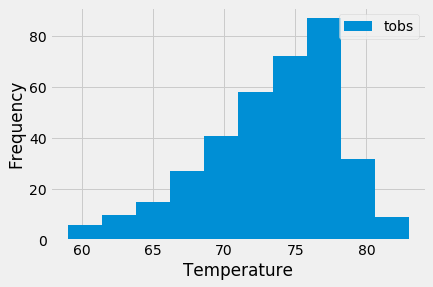

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).\
            filter(Measurement.station == 'USC00519281').first()
# print(last_date)

# Calculate the date one year from the last date in data set.
year_ago2 = dt.date(2017, 8, 18) - dt.timedelta(days=365)

# Perform a query to retrieve the data 
query3 = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago2).all()

# Save the query results as a Pandas DataFrame 
df = pd.DataFrame(query3, columns=['tobs'])
df.plot.hist()
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc = "upper right")
# plt.tight_layout()
plt.show()

# Close session

In [19]:
# Close Session
session.close()